# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Read raw data

In [3]:
#these data is download from udacity, the format is a little bit different with the original data
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=',')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=',')

#drop the "Unamed: 0" column  # this column is added when saving the data from the Udacity workspace
azdias.drop('Unnamed: 0',axis=1,inplace=True)
customers.drop('Unnamed: 0',axis=1,inplace=True)

/home/fafun/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias.shape,customers.shape

((891221, 366), (191652, 369))

### Merge two datasets into one

Add one column to label the dataset; Merge two datasets into one can save energy when cleaning the data

In [5]:
# add one column to the data
azdias["label"]="Azdias"
customers["label"]="Customers"

#merge two dataset together
merge_data=pd.concat([azdias, customers])

#release memory
del azdias
del customers

#print current shape of merged dataset
merge_data.shape

(1082873, 370)

### Check the type of each column

In [12]:
#check the "object" type columns
temp=merge_data.dtypes
for i in temp[temp=="object"].index:
    print(colored(i, 'red')," : \n" ,merge_data[i].unique())


CAMEO_DEUG_2015  : 
 [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
CAMEO_DEU_2015  : 
 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']
CAMEO_INTL_2015  : 
 [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX']
CUSTOMER_GROUP  : 
 [nan 'MULTI_BUYER' 'SINGLE_BUYER']
D19_LETZTER_KAUF_BRANCHE  : 
 [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DE

### Data cleaning

In [60]:
def str2float(x):
    if type(x)==str:
        return eval(x)
    else:
        return x

In [61]:
def data_cleaning(df):
    '''
    Cleaning the data: replace some values,change string into number and change some columns into categories and datatime.
    
    Parameters:
    INPUT:
    df(Dataframe): the dataset which will be cleaned
    
    OUTPUT:
    df(Datafrem): the cleaned dataset
    '''
    
    for column in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']:
        try:
            df[column][(df[column]=="X")|(df[column]=="XX")]=np.nan
        except:
            pass
    for column in ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
        df[column]=df[column].apply(str2float)
    
    #change the catergory columns into number
    for column in ["CAMEO_DEU_2015","D19_LETZTER_KAUF_BRANCHE","OST_WEST_KZ",]:
        df[column] = pd.Categorical(df[column])
        df[column] = df[column].cat.codes
        
    #extract the time,and keep the year   
    df["EINGEFUEGT_AM"]=pd.to_datetime(df["EINGEFUEGT_AM"]).dt.year

    #change all the unknown back to nan  #this step is not exactly correct, because some unknown data is labled as 0 and 9.
    for column in df.columns.values:
        try:
            df[column][df[column]==-1]=np.nan
        except:
            pass    
    return df

In [41]:
merge_data=data_cleaning(merge_data)

/home/fafun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/fafun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
#check the "object" type columns again
temp=merge_data.dtypes
for i in temp[temp=="object"].index:
    print(i)
    print(merge_data[i].unique())

PRODUCT_GROUP
[nan 'COSMETIC_AND_FOOD' 'FOOD' 'COSMETIC']
label
['Azdias' 'Customers']


From the result above, we can see only two variables are not number. We will not use these two variable when doing analysis.

### Data visualization

Compare the distribution of features between AZDIAS and CUSTOMERS datasets.

In [51]:
def visual(x= "AGER_TYP", y= "Prop",hue ="label",plot=False):
    #plot the distribution of variable x in the Azdias and customers dataset
    prop_df = (merge_data[x]
               .groupby(merge_data[hue])
               .value_counts(normalize=True)
               .rename(y)
               .reset_index())

    sns.barplot(x=x, y=y, hue=hue, data=prop_df, )
    if plot:
        plt.show()
    else:
        plt.savefig(x+".png")
        plt.clf()

#### Plot all the  distribution of features and save them as png files

In [ ]:
#Get the list of every variable, and delete some special columns
plot_list=list(merge_data.columns.values)
plot_list.remove("LNR")
plot_list.remove("label")

#plot the distribution of every variable in the Azdias and customers
for col in plot_list[250:]:
    #print(col)
    visual(x=col)

#### Plot some distribution of features

##### - different distribution between AZDIAS and CUSTOMERS datasets

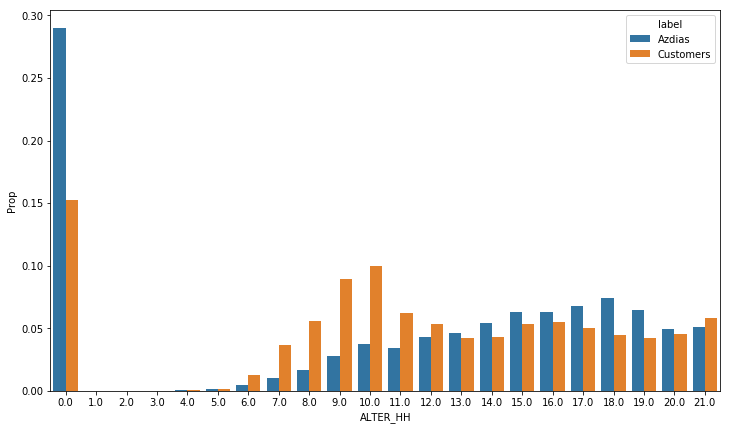

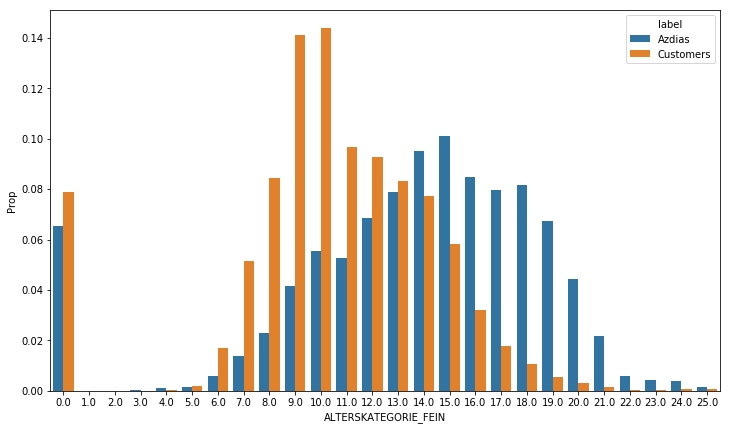

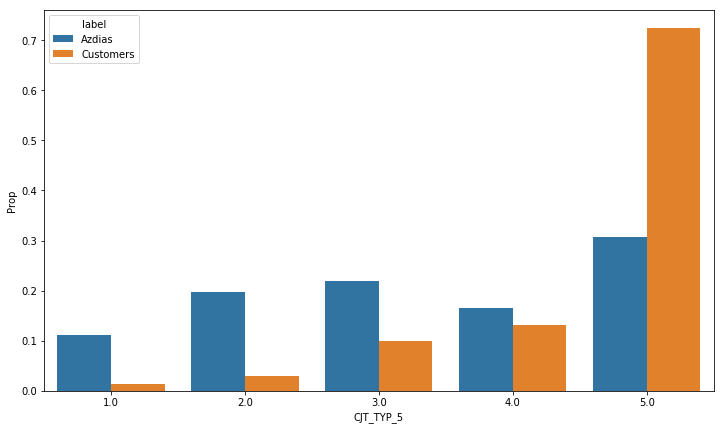

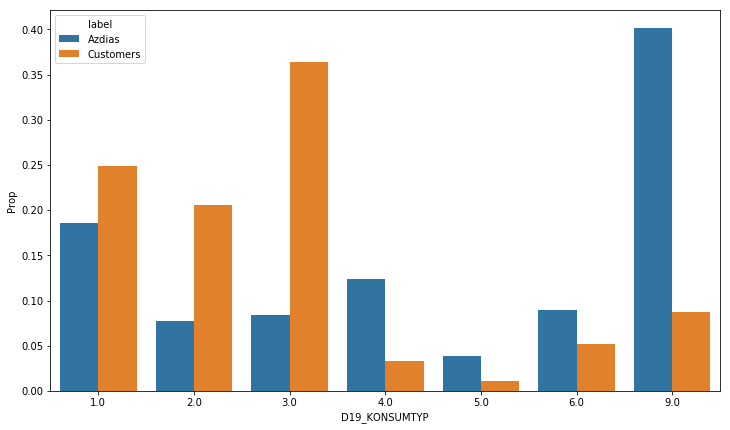

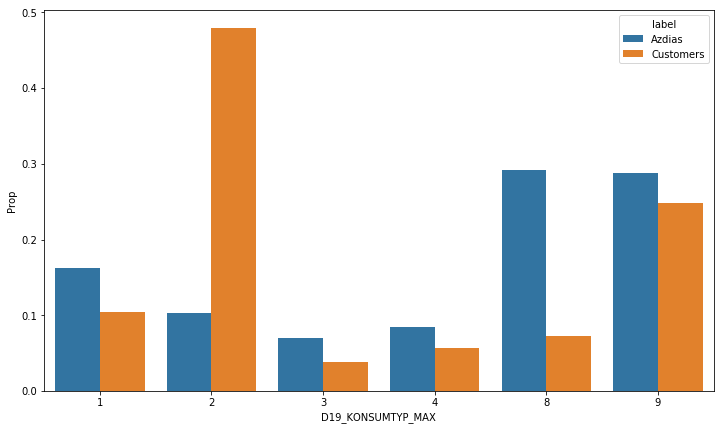

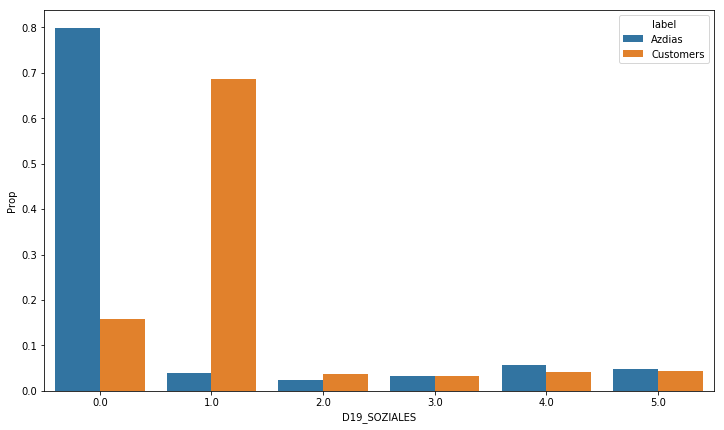

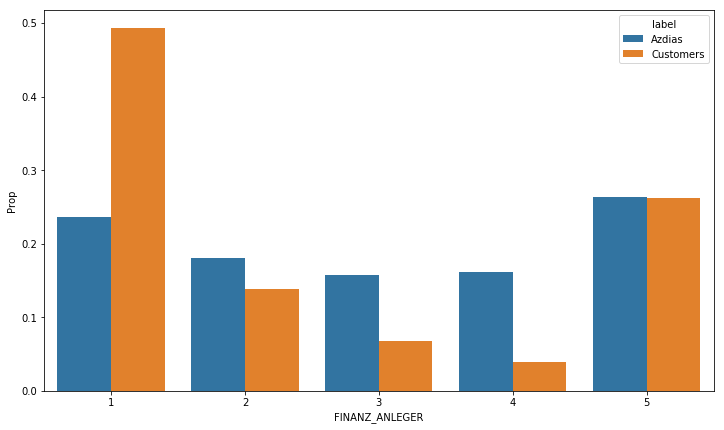

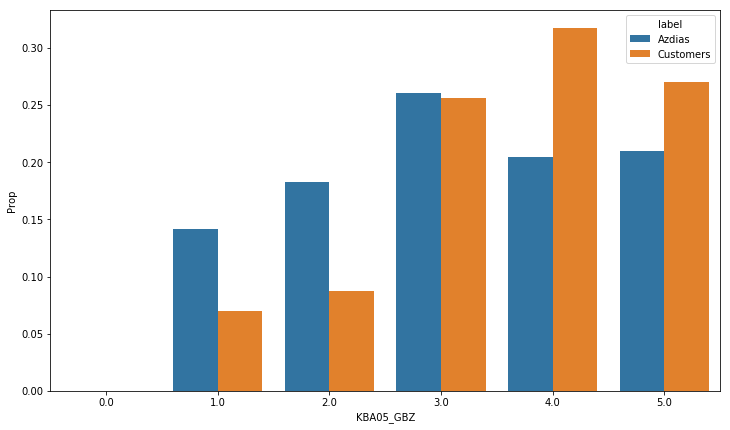

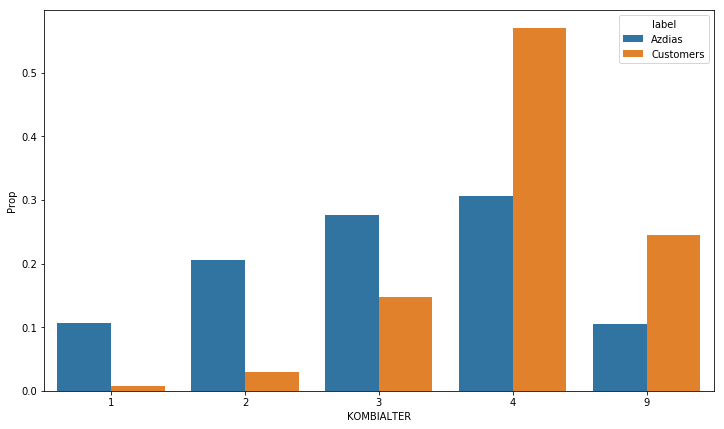

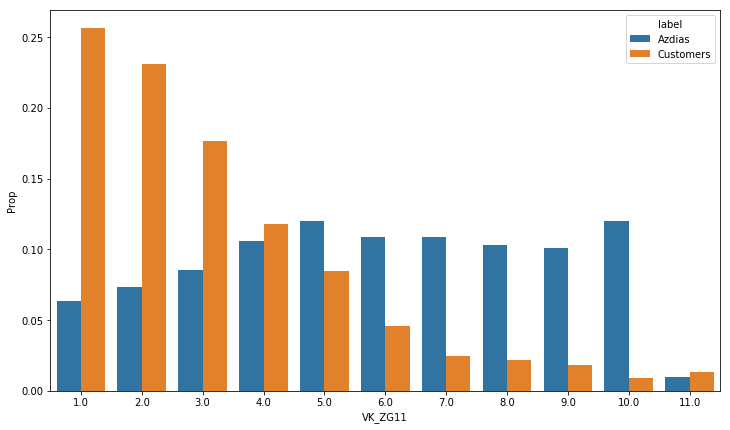

In [56]:
#Based on the visualization result, plot some variables have significant different distribution in two dataset
variables_list=["ALTER_HH","ALTERSKATEGORIE_FEIN","CJT_TYP_5","D19_KONSUMTYP","D19_KONSUMTYP_MAX",
               "D19_SOZIALES","FINANZ_ANLEGER","KBA05_GBZ","KOMBIALTER","VK_ZG11"]

for col in variables_list:
    #print(col)
    plt.figure(figsize=(12,7))
    visual(x=col,plot=True)

##### - similar distribution between AZDIAS and CUSTOMERS datasets

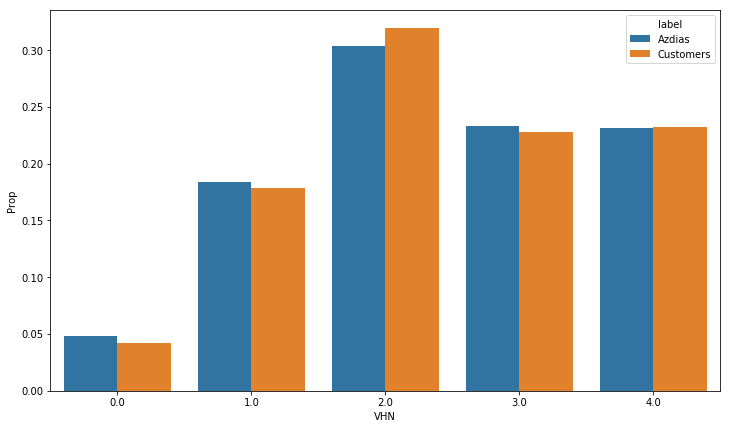

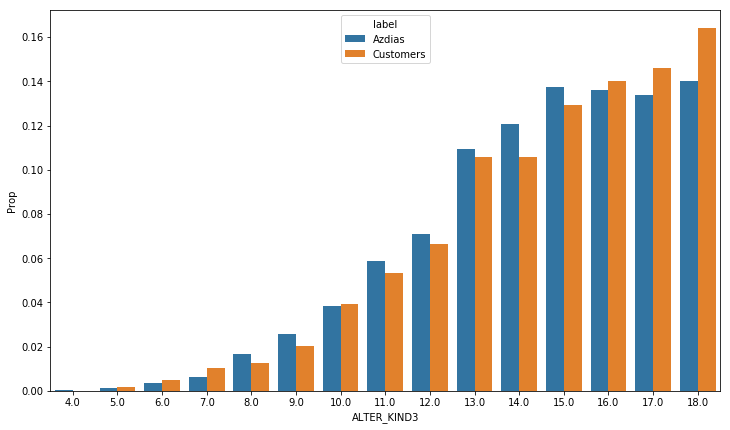

In [57]:
variables_list=["VHN", "ALTER_KIND3"]

for col in variables_list:
    #print(col)
    plt.figure(figsize=(12,7))
    visual(x=col,plot=True)

In [1]:
import pickle

file_Name = "merged_data.pickle"
# we open the file for reading
fileObject = open(file_Name,'rb')  
# load the object from the file into var b
merge_data = pickle.load(fileObject) 

### Check missing values

In [2]:
temp_desc=merge_data.describe()
rate=temp_desc.loc["count",:]/len(merge_data)

#print the columns which has more than 20% missing values
print("  Name           Missing")
1-rate[rate<0.7]

  Name           Missing


AGER_TYP           0.710711
ALTER_KIND1        0.914280
ALTER_KIND2        0.968049
ALTER_KIND3        0.993125
ALTER_KIND4        0.998669
CUSTOMER_GROUP     0.823015
EXTSEL992          0.682846
KK_KUNDENTYP       0.643242
ONLINE_PURCHASE    0.823015
Name: count, dtype: float64

### Drop the columns which have more than 20% missing values

In [3]:
dorp_list=rate[rate<0.7].index.values
merge_data.drop(dorp_list,axis=1,inplace=True)

In [4]:
dorp_list

array(['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'CUSTOMER_GROUP', 'EXTSEL992', 'KK_KUNDENTYP',
       'ONLINE_PURCHASE'], dtype=object)

### Fill nan values as -1

In [5]:
#merge_data=merge_data.fillna(merge_data.mean())
merge_data=merge_data.fillna(-1)

In [6]:
merge_data.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP,label
0,-1.0,-1.0,2,-1.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,Azdias
1,9.0,21.0,1,0.0,2,11.0,0.0,0.0,2.0,12.0,...,0.0,4.0,8.0,11.0,10.0,9.0,4.0,3.0,5,Azdias
2,9.0,17.0,3,17.0,2,10.0,0.0,0.0,1.0,7.0,...,0.0,2.0,9.0,9.0,6.0,9.0,2.0,3.0,5,Azdias
3,1.0,13.0,4,13.0,2,1.0,0.0,0.0,0.0,2.0,...,1.0,0.0,7.0,10.0,11.0,9.0,7.0,-1.0,3,Azdias
4,1.0,14.0,3,20.0,1,3.0,0.0,0.0,4.0,3.0,...,0.0,2.0,3.0,5.0,4.0,9.0,3.0,2.0,4,Azdias


### Save the filled data into pickle file

In [7]:
import pickle


file_Name = "merged_data_filled2.pickle"
# open the file for writing
fileObject = open(file_Name,'wb') 

# this writes the object a to the
# file named 'testfile'
pickle.dump(merge_data,fileObject)  
# here we close the fileObject
fileObject.close()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [8]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Read pickle file

In [10]:
import pickle
import pandas as pd
from sklearn.cluster import KMeans

file_Name = "merged_data_filled2.pickle"
# we open the file for reading
fileObject = open(file_Name,'rb')  
# load the object from the file into var b
merge_data = pickle.load(fileObject) 

#Because the dataset is huge, here I only choose 40% of total dataset to process the unsupervised learning
merge_data = merge_data.sample(frac=0.3).reset_index(drop=True)

merge_data.shape

(324862, 361)

### Drop unnecessary columns

In [11]:
#change the label into numerical
merge_data["label"][merge_data["label"]=="Azdias"]=1
merge_data["label"][merge_data["label"]=="Customers"]=0

label=merge_data["label"]
#drop the unnecessary columns
merge_data.drop("label",axis=1,inplace=True)
merge_data.drop("PRODUCT_GROUP",axis=1,inplace=True)
merge_data.drop("LNR",axis=1,inplace=True)

/home/fafun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/fafun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### One hot encoding

For some variables, like "very high, high, average, low, very low", we could use number to indicate the strength. However, for some category variables, we need use one hot coding to encoding them.

In [12]:
dummy_list=["CJT_GESAMTTYP","D19_KONSUMTYP","D19_KK_KUNDENTYP","GEBAEUDETYP","GFK_URLAUBERTYP","LP_FAMILIE_FEIN",
           "LP_STATUS_FEIN","PRAEGENDE_JUGENDJAHRE","TITEL_KZ","ZABEOTYP"]
cols=merge_data.columns.values

for name in dummy_list:
    if name in cols:
        print(name)
        dummies=pd.get_dummies(merge_data[name])
        merge_data = pd.concat([merge_data, dummies], axis=1)
        merge_data.drop(name,axis=1,inplace=True)

CJT_GESAMTTYP
D19_KONSUMTYP
GEBAEUDETYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_STATUS_FEIN
PRAEGENDE_JUGENDJAHRE
TITEL_KZ
ZABEOTYP


### Normalization

In [13]:
x = merge_data.values #returns a numpy array
scaler = StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

### PCA dimension reduction

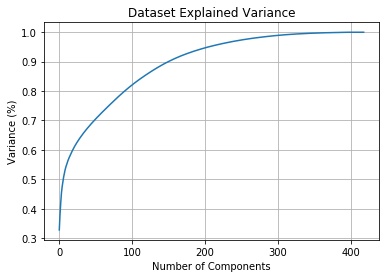

In [9]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(x_scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.grid()
plt.show()

### t-SNE visualization

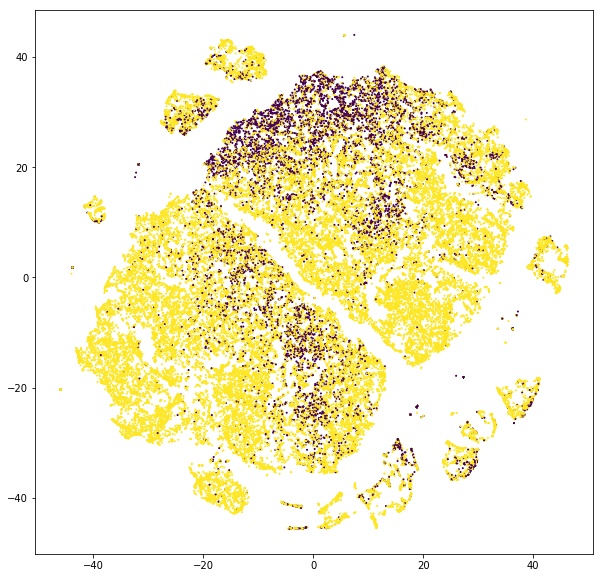

In [46]:
#When choose a large number of the principle components, it takes very long time to fitting. Here I set the n_components as 10.
pca = PCA(n_components=10)
dataset = pca.fit_transform(x_scaled)

# Defining Model
model = TSNE(learning_rate=100)

# Fitting Model
transformed = model.fit_transform(dataset)
# Plotting 2d t-Sne
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]
plt.figure(figsize=(10,10))
plt.scatter(x_axis, y_axis, c=label.values,s=1)
plt.show()

### K-means clustering

In [14]:
#PCA reduction
pca = PCA(n_components=300)
dataset = pca.fit_transform(x_scaled)

In [ ]:
# to determine the number of clusters
costs=[]
for k in range(3,40):
    kmeans = KMeans(n_clusters=k, random_state=0,n_jobs=-1).fit(dataset)
    costs.append(kmeans.inertia_)
    
    
#change of distance with the number of culsters
plt.plot(range(3,30),costs)
plt.xlabel("number of cluster")
plt.ylabel("Sum of distance")
plt.show()

#### Based on the elbow point above, I set 8 as the number of cluster 

/home/fafun/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


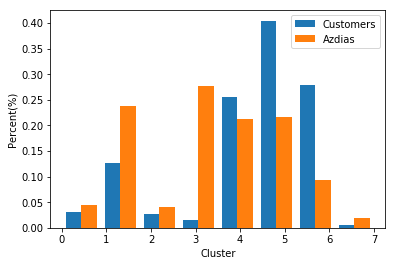

In [15]:
#Training the model

"""
training the K-means model, make prediction and plot out the distribution in each cluster

PARAMETERS:
n_clusters(INT): number of culsters

"""
n_clusters=8

kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_jobs=-1).fit(dataset)

#extract the customers and general population from dataset, predict them by the trained model
Customers=dataset[label.values==0]
Azdias=dataset[label.values==1]
cus=kmeans.predict(Customers)
azd=kmeans.predict(Azdias)
plt.hist([cus, azd],label=['Customers', 'Azdias'],bins=n_clusters,normed=True)
plt.legend(loc=0)
plt.xlabel("Cluster")
plt.ylabel("Percent(%)")
plt.show()

#### The figure above shows the distribution of customers and general population in each cluster. It is interesting to find that most individual in cluster 3 are general population and large portion of people in cluster 5 and 6 are  mail-order customers. 

### Compare the different between cluster 3 and cluster 6

In [16]:
# extract the original data
Customers_originaldata=merge_data[label.values==0]
Azdias_originaldata=merge_data[label.values==1]

ALTER_HH


/home/fafun/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fafun/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


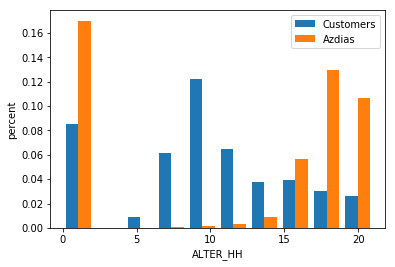

CJT_TYP_5


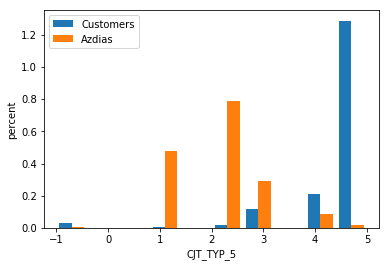

D19_KONSUMTYP_MAX


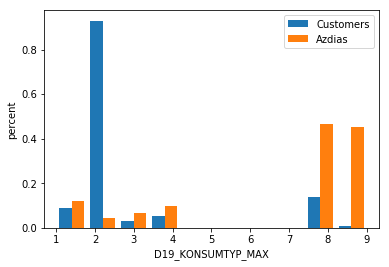

D19_SOZIALES


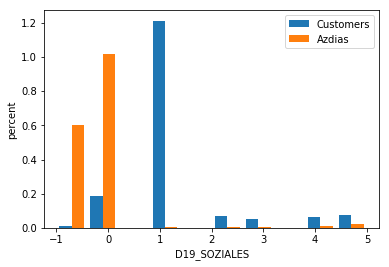

FINANZ_ANLEGER


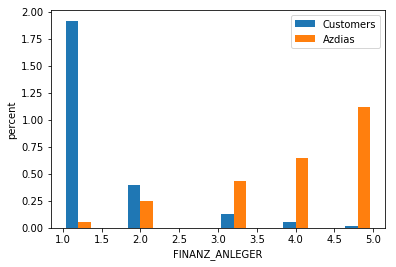

KBA05_GBZ


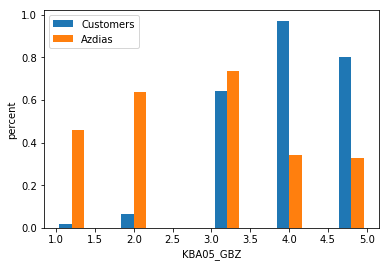

KOMBIALTER


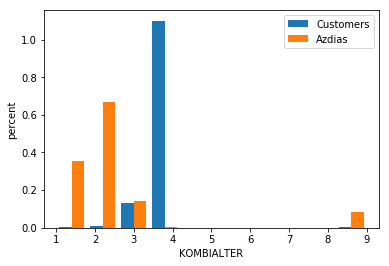

VK_ZG11


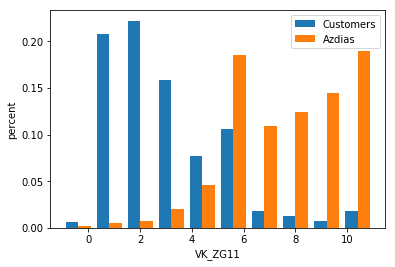

In [34]:
# As we see in the data visulization part, the distribution of some variable is different 
variables_list=["ALTER_HH","CJT_TYP_5","D19_KONSUMTYP_MAX","D19_SOZIALES",
               "FINANZ_ANLEGER","KBA05_GBZ","KOMBIALTER","VK_ZG11"]

#compare the difference in cluster 5 and cluster 7
for name in variables_list:
    print(name)
    Customers_cluster=Customers_originaldata[cus==5]
    Azdias_cluster=Azdias_originaldata[azd==3]
    plt.hist([Customers_cluster[name],Azdias_cluster[name]],normed=1,label=['Customers','Azdias'])
    plt.legend()
    plt.xlabel(name)
    plt.ylabel("percent")
    plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [68]:
from termcolor import colored
from sklearn.model_selection import train_test_split
import lightgbm as lgb

### Read data

In [43]:
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=',')
mailout_train.drop('Unnamed: 0',axis=1,inplace=True)
print("There are {} individuals in the traing dataset".format(len(mailout_train)))
print("There are {} individuals response the mail-out in the traing dataset".format(len(mailout_train[mailout_train.RESPONSE==1])))

There are 42962 individuals in the traing dataset
There are 532 individuals response the mail-out in the traing dataset


In [54]:
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=',')
mailout_test.drop('Unnamed: 0',axis=1,inplace=True)

/home/fafun/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Merge files

In [55]:
merge_data=pd.concat([mailout_train, mailout_test])
len_train=len(mailout_train)

### Check types

In [58]:
temp=merge_data.dtypes
for i in temp[temp=="object"].index:
    print(colored(i, 'red')," : \n" ,merge_data[i].unique())

CAMEO_DEUG_2015  : 
 [5.0 2.0 7.0 4.0 nan 3.0 6.0 1.0 8.0 9.0 '4' '6' '2' '9' '8' '7' '3' '1'
 '5' 'X']
CAMEO_DEU_2015  : 
 ['5D' '5B' '2D' '7B' '4C' '5C' nan '3D' '5A' '2C' '4A' '6B' '1A' '8D' '4B'
 '7A' '4E' '3A' '7C' '9D' '8A' '5E' '8B' '3C' '6E' '4D' '2B' '3B' '7E' '2A'
 '6C' '1C' '6D' '7D' '1D' '8C' '9A' '9B' '9C' '9E' '6F' '1E' '6A' '5F' '1B'
 'XX']
CAMEO_INTL_2015  : 
 [34.0 32.0 14.0 41.0 24.0 33.0 nan 25.0 31.0 22.0 43.0 13.0 55.0 23.0 54.0
 51.0 45.0 12.0 44.0 35.0 15.0 52.0 '23' '44' '14' '55' '51' '45' '43' '22'
 '54' '24' '25' '13' '12' '35' '33' '41' '15' '52' '31' '32' '34' 'XX']
D19_LETZTER_KAUF_BRANCHE  : 
 ['D19_UNBEKANNT' 'D19_TELKO_MOBILE' 'D19_LEBENSMITTEL' 'D19_BEKLEIDUNG_GEH'
 'D19_BUCH_CD' nan 'D19_NAHRUNGSERGAENZUNG' 'D19_SCHUHE' 'D19_SONSTIGE'
 'D19_HAUS_DEKO' 'D19_FREIZEIT' 'D19_ENERGIE' 'D19_VOLLSORTIMENT'
 'D19_BANKEN_REST' 'D19_VERSICHERUNGEN' 'D19_KINDERARTIKEL' 'D19_TECHNIK'
 'D19_DROGERIEARTIKEL' 'D19_BEKLEIDUNG_REST' 'D19_WEIN_FEINKOST'
 'D19_HANDWERK'

### Data cleaning -- using a function defined in part 1

In [62]:
merge_data=data_cleaning(merge_data)

/home/fafun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/fafun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Check missing values, and delete the columns which have more than 25% missing values

In [63]:
temp_desc=merge_data.describe()
rate=temp_desc.loc["count",:]/len(merge_data)
#print the columns which has more than 20% missing values
rate[rate<0.75].index

Index(['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'KK_KUNDENTYP', 'RESPONSE'],
      dtype='object')

In [64]:
drop_list=['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'KK_KUNDENTYP',]
merge_data.drop(drop_list,axis=1,inplace=True)

### Fill nan values with -1

In [65]:
#merge_data=merge_data.fillna(merge_data.mean())
merge_data=merge_data.fillna(-1)

### one hot encoding

In [66]:
dummy_list=["CJT_GESAMTTYP","D19_KONSUMTYP","D19_KK_KUNDENTYP","GEBAEUDETYP","GFK_URLAUBERTYP","LP_FAMILIE_FEIN",
           "LP_STATUS_FEIN","PRAEGENDE_JUGENDJAHRE","TITEL_KZ","ZABEOTYP","CAMEO_DEU_2015","CAMEO_INTL_2015"]
cols=merge_data.columns.values

for name in dummy_list:
    if name in cols:
        print(name)
        dummies=pd.get_dummies(merge_data[name],prefix=name)
        merge_data = pd.concat([merge_data, dummies], axis=1)
        merge_data.drop(name,axis=1,inplace=True)

CJT_GESAMTTYP
D19_KONSUMTYP
GEBAEUDETYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_STATUS_FEIN
PRAEGENDE_JUGENDJAHRE
TITEL_KZ
ZABEOTYP
CAMEO_DEU_2015
CAMEO_INTL_2015


### Drop unnecessary columns

In [67]:
Y_train=merge_data.RESPONSE.values[:len_train]
merge_data.drop("RESPONSE",axis=1,inplace=True)
merge_data.drop("LNR",axis=1,inplace=True)

### Split the training and testing dataset

In [69]:
X=merge_data.iloc[:len_train,:]
Test=merge_data.iloc[len_train:,:]
X_train, X_test, y_train, y_test = train_test_split(X, Y_train, test_size=0.1, random_state=42)

In [70]:
X_train.shape

(38665, 501)

### Modeling

In [82]:

model = lgb.LGBMRegressor(boosting_type='gbdt', 
        num_leaves=31, 
        max_depth=-1, 
        learning_rate=0.01, 
        n_estimators=200, 
        max_bin=255, 
        subsample_for_bin=50000, 
        objective=None, 
        min_split_gain=0, 
        min_child_weight=3,
        min_child_samples=10, 
        subsample=1, 
        subsample_freq=1, 
        colsample_bytree=1, 
        reg_alpha=0.1, 
        reg_lambda=0, 
        seed=17,
        silent=False, 
        nthread=-1)


model.fit(X_train, y_train, 
            eval_metric='rmse',
            eval_set=[(X_test,y_test )],
            verbose = False)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
       learning_rate=0.01, max_bin=255, max_depth=-1, min_child_samples=10,
       min_child_weight=3, min_split_gain=0, n_estimators=200, n_jobs=-1,
       nthread=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.1, reg_lambda=0, seed=17, silent=False, subsample=1,
       subsample_for_bin=50000, subsample_freq=1)

### Feature importance

In [93]:
df_importanct=pd.DataFrame(model.feature_importances_.T,index=merge_data.columns.values,columns=["importance",])
df_importanct.sort_values(by="importance",ascending=False,inplace=True)

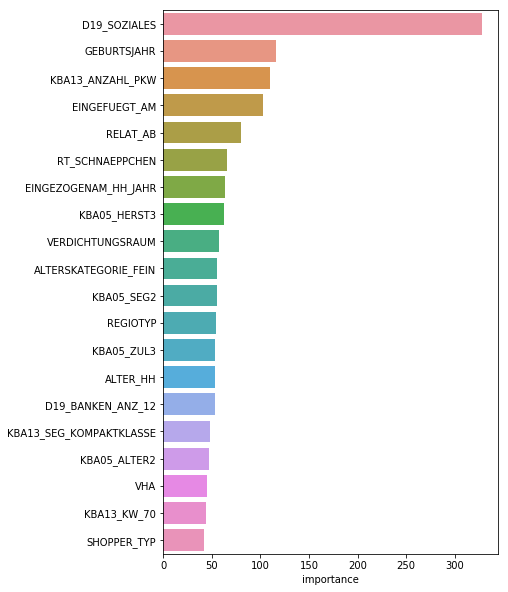

In [98]:
plt.figure(figsize=(6,10))
sns.barplot(x=df_importanct.importance[:20],y=df_importanct.index[:20])
plt.show()

### Grid search for better parameters

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [ ]:
parameters = {
        "num_leaves":[31,20,], 
        "learning_rate":[0.01,0.05,], 
        "n_estimators":[100,200,], 
        'max_bin':[128,255], 
        'subsample_for_bin':[5000,100000], 
        'min_split_gain':[0,0.1,0.01], 
        'min_child_weight':[1,3,],
        'min_child_samples':[10,20,], 
        'subsample':[1,2,], 
        'subsample_freq':[1,2,], 
        "bagging_fraction":[1,],
        'reg_alpha':[0.1,] ,
         'nthread':[-1,]
}

model_lgb = lgb.LGBMRegressor()
model = GridSearchCV(model_lgb, parameters)
model.fit(X_train, y_train)

In [72]:
#make prediction
y_pre=model.predict(X_test)

### calculate ROC AUC score
roc_auc_score(y_test, y_pre)

0.79085196328598084

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [221]:
#mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=',')
#mailout_test.drop('Unnamed: 0',axis=1,inplace=True)

In [76]:
test_pre=model.predict(Test)
test_pre

array([ 0.04432734,  0.02461367,  0.00558428, ...,  0.02022524,
        0.02263871,  0.01353582])

In [77]:
result=pd.DataFrame()
result["LNR"]=mailout_test.LNR
result["RESPONSE"]=test_pre
result.head()

,LNR,RESPONSE
0,1754,0.044327
1,1770,0.024614
2,1465,0.005584
3,1470,0.005334
4,1478,0.005053


### Save data to submission file

In [78]:
result.to_csv("submission.csv",index=False)